In [1]:
import time
import timeit
from IPython import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, mixture
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

from itertools import cycle, islice
from math import ceil
from tqdm import tqdm
from ard_em import GaussianMixtureARD
import h5py
import shutil

import sys
sys.path.append('../../')

from evaluation import *
np.random.seed(10)
%matplotlib inline

/opt/conda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Подготовим данные

In [2]:
column_names = 'label, lepton 1 pT, lepton 1 eta, lepton 1 phi, lepton 2 pT, lepton 2 eta, lepton 2 phi, missing energy magnitude, missing energy phi, MET_rel, axial MET, M_R, M_TR_2, R, MT2, S_R, M_Delta_R, dPhi_r_b, cos(theta_r1)'.split(', ')
data = pd.read_csv('../../../SUSY.csv', header=None, names=column_names)

In [3]:
data.head()

,label,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


In [4]:
data.shape

(5000000, 19)

Делим выборку на признаки и таргеты. Нормируем признаки.

$X_{new} = \frac{X - \mu}{\sigma}$

In [5]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [6]:
min_class_size = min(X_data[np.where(labels==0)[0]].shape[0], X_data[np.where(labels==1)[0]].shape[0])

In [7]:
min_class_size

2287827

In [8]:
X_0 = X_data[np.where(labels==0)[0]]
X_1 = X_data[np.where(labels==1)[0]]

In [9]:
np.concatenate((X_0[:min_class_size], X_1[:min_class_size])).shape

(4575654, 18)

In [10]:
X_data = np.concatenate((X_0[:min_class_size], X_1[:min_class_size]))
labels = np.concatenate((np.zeros((min_class_size,1)), np.ones((min_class_size,1)))).ravel()

Разбиваем на train(8% от всех данных) и test(2%)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), 
                                         stratify=labels, train_size=400000, test_size=100000, random_state=5)

In [13]:
indx_train = np.random.permutation(indx_train)
indx_test = np.random.permutation(indx_test)

In [14]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

Разбиваем объекты по классам

In [15]:
X_good = X_train[np.where(y_train==0)[0]]
X_bad = X_train[np.where(y_train==1)[0]]

In [16]:
X_good.shape, X_train.shape, X_data.shape

((200000, 18), (400000, 18), (4575654, 18))

В прошлый раз данные как-то странно перемешивались, что ROC AUC для XGB оказался равен 0.5, так что здесь тоже оставил проверку на то, что все работает хорошо

In [17]:
import xgboost as xgb
import timeit

frac = 0.25
if frac > 1:
    end_ind = X_bad.shape[0]
else:   
    end_ind = int(X_bad.shape[0] * frac)

XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=100)
#Train and time classifier
start_time = timeit.default_timer()

XGBclassifier.fit(np.concatenate((X_good, X_bad[:end_ind])), 
        np.concatenate((np.zeros((X_good.shape[0],1)), np.ones((end_ind,1)))).ravel())
run_time = timeit.default_timer() - start_time

#Make Predictions
y_pred = XGBclassifier.predict_proba(X_test)[:,1]

#Print Results
print("Model Accuray with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec".format(run_time))

Model Accuray with all features: 73.39%
The AUC score with all features is 0.87
Run time with all features: 35.23 sec


/opt/conda/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


ROC AUC = 0.87 => все нормально

## Сгенерируем примеры используя GMM подход

Подберем оптимальное число компонент для GaussianMixture

In [17]:
gm = GaussianMixture(n_components=35, n_init=4, covariance_type="full", verbose=0)

In [18]:
%%time
sigma = 0.01
gm.fit(X_good + np.random.normal(0, sigma, X_good.shape))

CPU times: user 22min 31s, sys: 1min 52s, total: 24min 23s
Wall time: 24min 19s


In [19]:
gm.bic(X_good)

-112496.9081242989

Генерируем выборку размера исходной нейтральной следующим образом:
- Для каждой компоненты смеси распределения, сэмплируем свои примеры с востановленными матожиданием и матрицей ковариаций
- Количество примеров для компоненты пропорционально ее вкладу в смесь

In [20]:
from scipy.stats import multivariate_normal

In [21]:
n_samples = X_good.shape[0] * 5

In [22]:
gen = np.array(multivariate_normal.rvs(mean=gm.means_[0], cov=gm.covariances_[0], 
                                       size=ceil(gm.weights_[0]*n_samples)))
for d in range(1, gm.n_components):
    gen=np.vstack((
        gen, multivariate_normal.rvs(mean=gm.means_[d], cov=gm.covariances_[d], size=ceil(gm.weights_[d]*n_samples))
    ))
np.random.shuffle(gen)
gen = np.array(gen)[:n_samples]

Посчитаем плотности вероятности на сгенерированных объектах для каждой компоненты смеси

In [23]:
probabilities = np.empty((gm.n_components, gen.shape[0]))

In [24]:
for d in range(gm.n_components):
    probabilities[d] = multivariate_normal.pdf(gen, mean=gm.means_[d], cov=gm.covariances_[d], allow_singular=True)

In [25]:
gen.shape

(1000000, 18)

Выберем для каждого объекта наибольшую вероятность по всем компонентам и инвертируем это значение для получения веса

Т.е. нам интересны те примеры, которые мало вероятно появляются в восстановленной смеси распределения(необычное поведение == аномалия)

In [26]:
maxprob = np.max(probabilities, axis=0)
gen_w = 1./(maxprob + 1e-2)

Веса ограничены сверху 100. Из этого графика мало что понятно, так как точек слигком много. Можно сказаль лишь то, что около граничных значений весов точек намного больше, чем в середине.

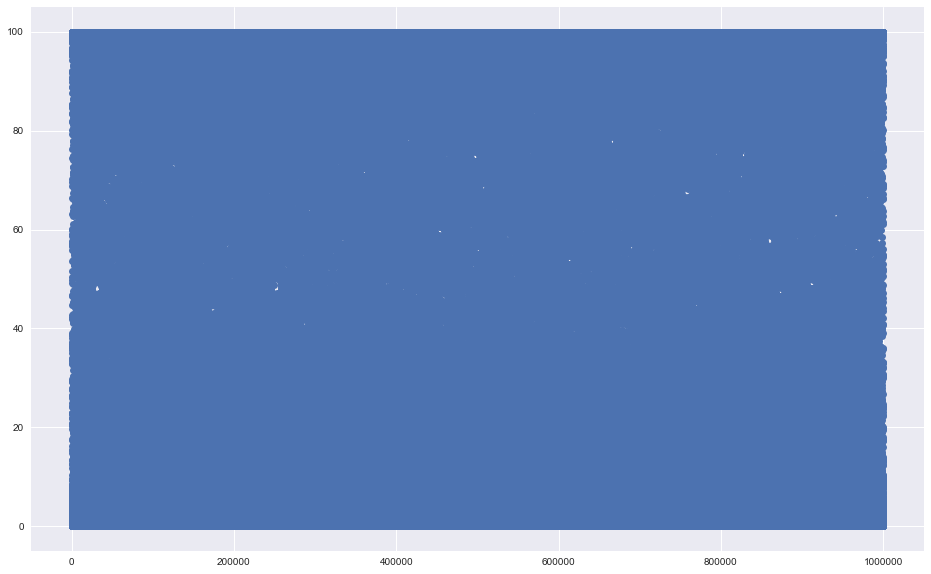

In [27]:
plt.figure(figsize=(16, 10))
plt.scatter(np.arange(len(gen_w)), gen_w, linewidths=0.00001)
plt.show()

Нормируем полученные веса

In [28]:
weights = np.ones((n_samples, 1)) #X_train.shape[0]

In [29]:
gen_w_normed = gen_w/np.sum(gen_w)*np.sum(weights)

In [30]:
gen_w_normed.sum(), np.sum(weights)

(1000000.0000000005, 1000000.0)

In [31]:
y1 = np.zeros((n_samples,1))
y2 = np.ones((gen.shape[0],1))

In [32]:
X_mix = np.vstack((gen, X_good)) 

y_mix = np.vstack((y2, y1))

weights_mix = np.vstack((gen_w_normed.reshape(-1,1), weights.reshape(-1,1))).reshape(-1)

In [33]:
weights_mix.shape, y_mix.shape

((2000000,), (2000000, 1))

In [34]:
X_gen = gen
y_gen = np.ones((X_gen.shape[0],1))

weights_gen = gen_w_normed.reshape(-1)

In [35]:
w_gen = weights_gen

## Обучим на этом нейронку

Строит зависимость ошибок от эпохи

In [36]:
# summarize history for loss
def history_plot(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [37]:
ours_roc_aucs = {}
ours_pr_aucs = {}
ours_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

Реализуем функции для вычисления precision at recall

In [38]:
def p_at_r(y_test, y_pred, x):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    return max(precision[recall > x])

In [39]:
def _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        if descr in ours_p_at_r[recall]:
            # append the new number to the existing array at this slot
            ours_p_at_r[recall][descr].append((frac, p_at_r(y_test, y_pred, float(recall))))
        else:
            # create a new array in this slot
            ours_p_at_r[recall][descr] = [(frac, p_at_r(y_test, y_pred, float(recall)))]
            
def _eval_p_at_rs_flatten(y_test, y_pred, frac, ours_p_at_r, descr):
    for recall in ours_p_at_r.keys():
        ours_p_at_r[recall][descr] = (frac, p_at_r(y_test, y_pred, float(recall)))

Посмотрим на значения весов объектов в объединенной выборке

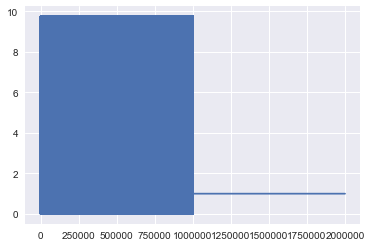

In [40]:
plt.plot(weights_mix)
plt.show()

Сохранение метрик

In [41]:
import json

def dump(saved_dict, folder, name):
    dict_for_json = {k: {kk: list(vv) for kk, vv in v.items()} if isinstance(v, dict) else list(v) 
                     for k, v in saved_dict.items()}
    with open(os.path.join(folder, name + ".json"), 'w', encoding="utf-8") as file:
        # writing
        json.dump(dict_for_json, file, indent=4, ensure_ascii=False)
    del dict_for_json
    
def create_metrics_folder(metrics_path):
    if not os.path.exists(metrics_path):
        os.makedirs(metrics_path)
    try:
        last_folder_n = max(list(map(lambda name: int(name), 
                                     filter(lambda name: os.path.isdir(os.path.join(metrics_path, name)) 
                                            and name.isdecimal(), os.listdir(metrics_path)))))
    except:
        last_folder_n = 0
    new_folder = os.path.join(metrics_path, str(last_folder_n + 1))
    old_folder = os.path.join(metrics_path, str(last_folder_n))
    os.makedirs(new_folder)    
    return new_folder, old_folder

# костыль, чтобы не сохранять разные словари отдельно
def dump_metrics(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(ours_pr_aucs, folder, "ours_pr_aucs")
    dump(ours_roc_aucs, folder, "ours_roc_aucs")
    dump(ours_p_at_r, folder, "ours_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

Графики метрик

In [42]:
def metric_boxplot(metric, ylabel='PR_AUC', ylim=None):
    n = len(metric.keys())
    plt.figure(figsize=(15, 7 * ceil(n/2)))

    for i, clf_name in enumerate(metric.keys()):
        plt.subplot(ceil(n/2), 2, i + 1)
        sns.boxplot(np.array(metric[clf_name])[:, 0]*100, np.array(metric[clf_name])[:, 1])
        plt.ylim(ylim)
        plt.xlabel("% of used anomalies")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.title(clf_name)

А теперь сама нейронка

In [43]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.visible_device_list = '1'

# graph = tf.Graph()
sess = tf.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [44]:
import os
import tensorflow as tf
tf.set_random_seed(1)

import keras
from keras.models import Sequential, Model
from keras import layers as L
from keras import backend as K

Простейшая сверточная сеть для двухклассовой классификации

In [45]:
def build_net(features_dim, alpha, l2=1e-5):
#     with tf.Graph().as_default():
    with tf.variable_scope('placeholders'):
        X = tf.placeholder('float32', shape=(None, features_dim), name='X')
        X_pos = tf.placeholder('float32', shape=(None, features_dim), name='X_pos')
        X_true_neg = tf.placeholder('float32', shape=(None, features_dim), name='X_true_neg')
        X_pseudo_neg = tf.placeholder('float32', shape=(None, features_dim), name='X_pseudo_neg')

        w_pos = tf.placeholder('float32', shape=(None), name='w_pos')
        w_true_neg = tf.placeholder('float32', shape=(None), name='w_true_neg')
        w_pseudo_neg = tf.placeholder('float32', shape=(None), name='w_pseudo_neg')

    tf_alpha = tf.constant(alpha, dtype='float32')

    net = Sequential()
    net.add(L.Dense(80, input_dim=features_dim, activation = 'relu', 
                    kernel_regularizer=keras.regularizers.l2(l2)))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.2))
    net.add(L.Dense(32, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(l2)))
    net.add(L.BatchNormalization())
    net.add(L.Dropout(0.1))
    net.add(L.Dense(1, activation='sigmoid'))

    # loss
    with tf.variable_scope(tf.get_variable_scope(), reuse=True):
        y_proba = net(X)
        y_pred = tf.round(y_proba)

        y_proba_pos = net(X_pos)
        y_proba_true_neg = net(X_true_neg)
        y_proba_pseudo_neg = net(X_pseudo_neg)
        
    loss_1 = -tf.reduce_mean(tf.multiply(w_pos, tf.log(y_proba_pos + 1e-7)))/2
    loss_2 = -tf.multiply(tf_alpha, tf.reduce_mean(tf.multiply(w_true_neg, tf.log(1 - y_proba_true_neg + 1e-7))))/2
    loss_3 = -tf.multiply((1 - tf_alpha), tf.reduce_mean(tf.multiply(w_pseudo_neg, 
                                                                     tf.log(1 - y_proba_pseudo_neg + 1e-7))))/2
    
    loss = 0
    loss += tf.cond(tf.is_nan(loss_1), lambda: 0., lambda: loss_1)
    loss += tf.cond(tf.is_nan(loss_2), lambda: 0., lambda: loss_2)
    loss += tf.cond(tf.is_nan(loss_3), lambda: 0., lambda: loss_3)
    
    for reg_loss in net.losses:
        loss = loss + reg_loss
    
#     tf_zero_shape = tf.constant([0, features_dim], dtype='int32')
#     loss = tf.cond(
#         tf.equal(tf.reduce_sum(tf.shape(X_pos) - tf_zero_shape), 0), lambda: 0., 
#         lambda: tf.reduce_mean(tf.multiply(w_pos, tf.log(y_proba_pos))))
#     loss += tf.cond(
#         tf.equal(tf.reduce_sum(tf.shape(X_true_neg) - tf_zero_shape), 0), lambda: 0., 
#         lambda: tf.multiply(tf_alpha, tf.reduce_mean(tf.multiply(w_true_neg, tf.log(1 - y_proba_true_neg)))))
#     loss += tf.cond(
#         tf.equal(tf.reduce_sum(tf.shape(X_pseudo_neg) - tf_zero_shape), 0), lambda: 0., 
#         lambda: tf.multiply((1 - tf_alpha), tf.reduce_mean(tf.multiply(w_pseudo_neg, tf.log(1 - y_proba_pseudo_neg)))))
#     loss = -loss/2
    
    
#     loss = -(tf.reduce_mean(tf.multiply(w_pos, tf.log(y_proba_pos))) +
#              tf.multiply(tf_alpha, tf.reduce_mean(tf.multiply(w_true_neg, tf.log(1 - y_proba_true_neg)))) +
#              tf.multiply((1 - tf_alpha), tf.reduce_mean(tf.multiply(w_pseudo_neg, tf.log(1 - y_proba_pseudo_neg))))
#             )/2
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
    gvs = optimizer.compute_gradients(loss)
    cliped_gvs = [(tf.clip_by_value(grad, -10., 10.), var) for grad, var in gvs]
    train_step = optimizer.apply_gradients(cliped_gvs)

#     train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
    return y_proba, y_pred, train_step, loss

In [46]:
def get_train_val_data(X_pos, X_true_neg, X_pseudo_neg, 
                       w_pos, w_true_neg, w_pseudo_neg, val_size=0.1):
    # join all datasets
    X = np.concatenate((
        X_pos,
        X_true_neg,
        X_pseudo_neg,
    ), axis=0)
    y = np.concatenate((
        np.zeros(X_pos.shape[0]),
        np.ones(X_true_neg.shape[0]),
        np.ones(X_pseudo_neg.shape[0]) * 2,
    ), axis=0)
    w = np.concatenate((
        w_pos,
        w_true_neg,
        w_pseudo_neg,
    ), axis=0)
    
    # shuffle
    idx = np.arange(y.shape[0])
    np.random.shuffle(idx)
    idx_train, idx_val = train_test_split(idx, stratify=y[idx], test_size=val_size, random_state=5)
    X_train, X_val = X[idx_train], X[idx_val]
    y_train, y_val = y[idx_train], y[idx_val]
    w_train, w_val = w[idx_train], w[idx_val]
    
    def batch_generator(data_tuple, batch_size=256):
        X, y, w = data_tuple
        idx = np.arange(y.shape[0])
        np.random.shuffle(idx)
        X, y, w = X[idx], y[idx], w[idx]
        for i in range(0, y.shape[0], batch_size):
            cur_y = y[i:i + batch_size]
            yield {
                'placeholders/X_pos:0': X[np.where(cur_y==0)[0] + i],
                'placeholders/X_true_neg:0': X[np.where(cur_y==1)[0] + i],
                'placeholders/X_pseudo_neg:0': X[np.where(cur_y==2)[0] + i],
                'placeholders/w_pos:0': w[np.where(cur_y==0)[0] + i],
                'placeholders/w_true_neg:0': w[np.where(cur_y==1)[0] + i],
                'placeholders/w_pseudo_neg:0': w[np.where(cur_y==2)[0] + i],
            }
            
    return (X_train, y_train, w_train), (X_val, y_val, w_val), batch_generator

In [47]:
# summarize losses
def loss_plot(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)
    plt.plot(x, train_loss)
    plt.plot(x, val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower left')
    plt.show()

In [48]:
def train_function(loss_fn, train_step_fn, 
                   X_good, X_bad, X_gen, 
                   w_good, w_bad, w_gen, 
                   s=sess, batch_size=256, val_size=0.1, n_epoches=130, verbose=1):
    train_data_tuple, val_data_tuple, batch_generator = get_train_val_data(
        X_good, X_bad, X_gen, w_good, w_bad, w_gen, val_size=val_size
    )
    train_loss = []
    val_loss = []
    for epoch in tqdm(range(1, n_epoches+1)):
        # train
        epoch_train_loss = []
        for train_dict in batch_generator(train_data_tuple, batch_size):
            epoch_train_loss.append(s.run([loss_fn, train_step_fn], train_dict)[0])
        
        # val
        epoch_val_loss = []
        for val_dict in batch_generator(val_data_tuple, batch_size):
            epoch_val_loss.append(s.run(loss_fn, val_dict))
        
        # loss
        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))
        if np.isnan(train_loss[-1]) or np.isnan(val_loss[-1]):
            print('Nan! N_epoch: {}'.format(epoch))
            return False, train_loss, val_loss
        
        # verbosity
        if verbose:
            print("Epoch: {}, train loss: {:.3f}, val loss: {:.3f}".format(
                epoch, train_loss[-1], val_loss[-1]
            ))
    return True, train_loss, val_loss

Пример запуска обучения модели

 25%|██▌       | 1/4 [01:19<03:58, 79.55s/it]

Epoch: 1, train loss: 0.576, val loss: 0.507


 50%|█████     | 2/4 [02:36<02:37, 78.79s/it]

Epoch: 2, train loss: 0.448, val loss: 0.389


 75%|███████▌  | 3/4 [03:54<01:18, 78.50s/it]

Epoch: 3, train loss: 0.378, val loss: 0.368


100%|██████████| 4/4 [05:12<00:00, 78.31s/it]

Epoch: 4, train loss: 0.360, val loss: 0.363


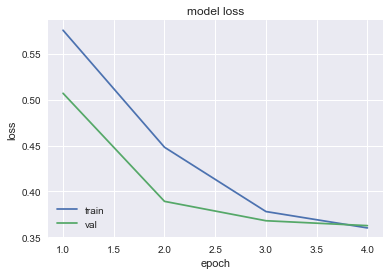

CPU times: user 9min 6s, sys: 3min 3s, total: 12min 9s
Wall time: 5min 20s


In [ ]:
%%time
batch_size = 256
val_size = 0.1
n_epoches = 4
verbose = 1
features_dim = X_good.shape[1]
alpha = 0.5

with tf.Graph().as_default():
    y_proba_fn, y_pred_fn, train_step_fn, loss_fn = build_net(features_dim, alpha=alpha)
    with tf.Session() as s:
        s.run(tf.global_variables_initializer())
        w_good = np.ones(X_good.shape[0])
        w_bad = np.ones(X_bad.shape[0])
        success, train_loss, val_loss = train_function(
            loss_fn, train_step_fn, 
            X_good, X_bad, X_gen,
            w_good, w_bad, w_gen,
            s=s, batch_size=batch_size, val_size=val_size, n_epoches=n_epoches, verbose=verbose
        )
        loss_plot(train_loss, val_loss)

In [ ]:
%%time
batch_size = 256
val_size = 0.1
n_epoches = 4
verbose = 1
features_dim = X_good.shape[1]
alpha = 0.5

with tf.Graph().as_default():
    y_proba_fn, y_pred_fn, train_step_fn, loss_fn = build_net(features_dim, alpha=alpha, l2=1e-7)
    with tf.Session() as s:
        s.run(tf.global_variables_initializer())
        w_good = np.ones(X_good.shape[0])
        w_bad = np.ones(X_bad.shape[0])
        success, train_loss, val_loss = train_function(
            loss_fn, train_step_fn, 
#             X_good[:batch_size*2], X_bad[:batch_size*2], X_gen[:batch_size*2],
#             w_good[:batch_size*2], w_bad[:batch_size*2], w_gen[:batch_size*2],
            X_good, np.empty(shape=(0, features_dim)), X_gen,
            w_good, np.empty(shape=(0)), w_gen,
            s=s, batch_size=batch_size, val_size=val_size, n_epoches=n_epoches, verbose=verbose
        )
        loss_plot(train_loss, val_loss)

 25%|██▌       | 1/4 [01:02<03:08, 62.97s/it]

Epoch: 1, train loss: 0.393, val loss: 0.241


 50%|█████     | 2/4 [02:05<02:05, 62.95s/it]

Epoch: 2, train loss: 0.205, val loss: 0.206


 75%|███████▌  | 3/4 [03:08<01:02, 62.96s/it]

Epoch: 3, train loss: 0.162, val loss: 0.146


Обучим нейронку с нашими весами

In [ ]:
fraction_of_negative_used = np.array([0.001, 0.01, 0.1, 0.5, 1, 5, 10, 25, 100]) / 100.
n_resplits = np.array([20, 20, 20, 20, 4, 4, 4, 4, 4])
n_evals_for_frac = np.zeros_like(fraction_of_negative_used)

In [ ]:
%%time
batch_size = 256
val_size = 0.1
n_epoches = 25
verbose = 1
l2 = 1e-7
features_dim = X_good.shape[1]
alpha = 0.25
metrics_path = './metrics/our/alpha_' + str(alpha)
errors = []

# weights
w_good = np.ones(X_good.shape[0])
w_bad = np.ones(X_bad.shape[0])

while np.sum(n_resplits - n_evals_for_frac) > 0:
    for i, frac in tqdm(enumerate(fraction_of_negative_used)):
        if n_evals_for_frac[i] >= n_resplits[i]:
            continue
        if frac > 1:
            end_ind = X_good.shape[0]
        else:   
            end_ind = int(X_good.shape[0] * frac)

        idx_good = np.random.permutation(X_good.shape[0])
        idx_bad = np.random.permutation(X_bad.shape[0])
        idx_gen = np.random.permutation(X_gen.shape[0])
        
        # fit and predict
        with tf.Graph().as_default():
            y_proba_fn, y_pred_fn, train_step_fn, loss_fn = build_net(features_dim, alpha=alpha, l2=l2)
            with tf.Session() as s:
                start_time = timeit.default_timer()
                s.run(tf.global_variables_initializer())
                success, train_loss, val_loss = train_function(
                    loss_fn, train_step_fn,
                    X_good[idx_good], X_bad[idx_bad[:end_ind]], X_gen[idx_gen],
                    w_good[idx_good], w_bad[idx_bad[:end_ind]], w_gen[idx_gen],
                    s=s, batch_size=batch_size, n_epoches=n_epoches, verbose=verbose
                )
                y_pred = s.run(y_proba_fn, {'placeholders/X:0': X_test})
                run_time = timeit.default_timer() - start_time
        try:     
            if success:
                # eval metrics
                if alpha in ours_pr_aucs:
                    # append the new number to the existing array at this slot
                    ours_pr_aucs[alpha].append((frac, average_precision_score(y_test, y_pred)))
                    ours_roc_aucs[alpha].append((frac, roc_auc_score(y_test, y_pred)))
                else:
                    # create a new array in this slot
                    ours_pr_aucs[alpha] = [(frac, average_precision_score(y_test, y_pred))]
                    ours_roc_aucs[alpha] = [(frac, roc_auc_score(y_test, y_pred))]
                _eval_p_at_rs(y_test, y_pred, frac, ours_p_at_r, descr=alpha)


                # plot metrics
                display.clear_output(wait=True)
                print("Run time: {:.2f} sec".format(run_time))
                loss_plot(train_loss, val_loss)
                metric_boxplot(ours_pr_aucs, ylabel='PR_AUC', ylim=(0.4, 0.9))
                plt.show()
                metric_boxplot(ours_roc_aucs, ylabel='ROC_AUC', ylim=(0.4, 0.9))
                plt.show()
                for k in ours_p_at_r.keys():
                    metric_boxplot(ours_p_at_r[k], ylabel='P@R_' + str(k), ylim=(0.4, 0.9))
                    plt.show()

                dump_metrics(metrics_path)
                n_evals_for_frac[i] += 1

                print("ROC_AUC: ", ours_roc_aucs[alpha][-1])
                print('alpha: ', alpha)
            else:
                print('Bad weights!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        except Exception as e:
            print('Some other reason!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print("Error: {0}".format(e))
            errors.append(e)
        print('n_evals_for_frac: ', n_evals_for_frac)
        print('n_errors: ', len(errors))

# Classic methods

## Unsupervised

In [72]:
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))

In [81]:
unsupervised_pr_aucs = {}
unsupervised_roc_aucs = {}
unsupervised_p_at_n = {
    10: {},
    100: {},
    200: {},
    500: {},
    1000: {},
    2000: {},
    5000: {},
}
unsupervised_p_at_r = {
    '0.8': {},
    '0.9': {}, 
    '0.95': {},
    '0.99': {},
}

In [74]:
def dump_metrics_un(metrics_path):
    folder, old_folder = create_metrics_folder(metrics_path)
    print(folder)

    dump(unsupervised_pr_aucs, folder, "unsupervised_pr_aucs")
    dump(unsupervised_roc_aucs, folder, "unsupervised_roc_aucs")
    dump(unsupervised_p_at_n, folder, "unsupervised_p_at_n")
    dump(unsupervised_p_at_r, folder, "unsupervised_p_at_r")
    
    shutil.rmtree(old_folder, ignore_errors=True)

In [75]:
def p_at_n_un(y_test, y_pred, n=10):
    try:
        ind = np.argpartition(y_pred[:, 0], -n)[-n:]
    except:
        ind = np.argpartition(y_pred, -n)[-n:]
    try:
        mean = np.mean(y_test[ind])
    except:
        mean = np.mean(y_test.iloc[ind])
    return mean

In [76]:
def _eval_p_at_ns(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        if descr in ours_p_at_n[n]:
            # append the new number to the existing array at this slot
            ours_p_at_n[n][descr].append((frac, p_at_n_un(y_test, y_pred, int(n))))
        else:
            # create a new array in this slot
            ours_p_at_n[n][descr] = [(frac, p_at_n_un(y_test, y_pred, int(n)))]
            
def _eval_p_at_ns_flatten(y_test, y_pred, frac, ours_p_at_n, descr):
    for n in ours_p_at_n.keys():
        ours_p_at_n[n][descr] = (frac, p_at_n_un(y_test, y_pred, int(n)))

0it [00:00, ?it/s]

One-Class SVM
recall_score  0.16634
precision_score  0.8543400102722136
f1_score  0.27846321252197204
confusion_matrix 
[[48582  1418]
 [41683  8317]]


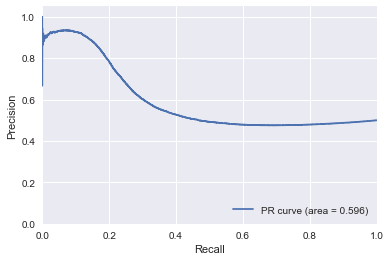

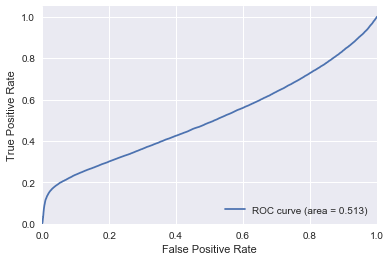

1it [20:34, 1234.38s/it]

Precision at recall:  0.8 = [(0, 0.5)]; 0.9 = [(0, 0.5)]; 0.95 = [(0, 0.5)]; 0.99 = [(0, 0.5)]
./metrics/unsupervised/5
Isolation Forest
recall_score  0.33444
precision_score  0.9186397846508817
f1_score  0.49035966159846345
confusion_matrix 
[[48519  1481]
 [33278 16722]]


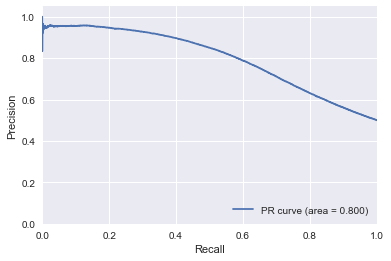

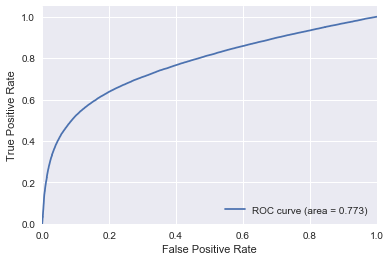

2it [23:33, 917.70s/it] 

Precision at recall:  0.8 = [(0, 0.6308386160784685)]; 0.9 = [(0, 0.5611991669680381)]; 0.95 = [(0, 0.5292708472612203)]; 0.99 = [(0, 0.5064869953138109)]
./metrics/unsupervised/6


In [82]:
from sklearn import svm
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor


classifiers_classic_uns = {
    "One-Class SVM": svm.OneClassSVM(nu=0.03,
                                     kernel="rbf", gamma=1e-5),
    "Isolation Forest": IsolationForest(n_estimators=500,
                                        max_samples=1500,
                                        contamination=0.03,
                                        random_state=10)
}

frac = 0
metrics_path = './metrics/unsupervised/'
for i, (clf_name, clf) in tqdm(enumerate(classifiers_classic_uns.items())):
        clf.fit(X_good)
        #scores_pred = clf.decision_function(X_test)
        y_pred = clf.predict(X_test)
#         y_pred = clf.decision_function(X_test)
        
        print (clf_name)
        print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
        print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
        print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
        print ("confusion_matrix ")
        print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))
        

        Score = clf.decision_function(X_test)
        
        
        precision, recall, _ = precision_recall_curve(-y_test_rescale, -Score)
        pr_auc = auc(recall, precision)
        unsupervised_pr_aucs[clf_name]=[(frac, pr_auc)]
        
        plt.figure()
        plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        fpr, tpr, _ = roc_curve(-y_test_rescale, -Score)
        roc_auc = auc(fpr, tpr)
        unsupervised_roc_aucs[clf_name]=[(frac, roc_auc)]
        
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
        
        _eval_p_at_rs(-y_test_rescale, -Score, frac, unsupervised_p_at_r, descr=clf_name)
        _eval_p_at_ns(-y_test_rescale, -Score, frac, unsupervised_p_at_n, descr=clf_name)
        
        print("Precision at recall: ", "; ".join(
            map(lambda k: "{} = {}".format(k, unsupervised_p_at_r[k][clf_name]), unsupervised_p_at_r.keys())
        ))
        dump_metrics_un(metrics_path)